In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from cs import CanonicalSystem

#%% define discrete dmp
class dmp_discrete():
    def __init__(self, n_dmps=1, n_bfs=100, dt=0, alpha_y=None, beta_y=None, **kwargs):
        self.n_dmps = n_dmps # number of data dimensions, one dmp for one degree
        self.n_bfs = n_bfs # number of basis functions
        self.dt = dt

        self.y0 = np.zeros(n_dmps)  # for multiple dimensions
        self.goal = np.ones(n_dmps) # for multiple dimensions

        alpha_y_tmp = 60 if alpha_y is None else alpha_y
        beta_y_tmp = alpha_y_tmp / 4.0  if beta_y is None else beta_y
        self.alpha_y = np.ones(n_dmps) * alpha_y_tmp
        self.beta_y = np.ones(n_dmps) * beta_y_tmp
        self.tau = 1.0
        self.delta = np.ones((n_dmps, 1))
        self.delta_2 = np.ones((n_dmps, 1))

        self.w = np.zeros((n_dmps, n_bfs)) # weights for forcing term
        self.psi_centers = np.zeros(self.n_bfs) # centers over canonical system for Gaussian basis functions
        self.psi_h = np.zeros(self.n_bfs) # variance over canonical system for Gaussian basis functions

        # canonical system
        self.cs = CanonicalSystem(dt=self.dt, **kwargs)
        self.timesteps = round(self.cs.run_time / self.dt)

        # generate centers for Gaussian basis functions
        self.generate_centers()

        # self.h = np.ones(self.n_bfs) * self.n_bfs / self.psi_centers # original
        self.h = np.ones(self.n_bfs) * self.n_bfs**1.5 / self.psi_centers / self.cs.alpha_x # chose from trail and error

        # reset state
        self.reset_state()

    # Reset the system state
    def reset_state(self):
        self.y = self.y0.copy()
        self.dy = np.zeros(self.n_dmps)
        self.ddy = np.zeros(self.n_dmps)
        self.cs.reset_state()

    def generate_centers(self):
        t_centers = np.linspace(0, self.cs.run_time, self.n_bfs) # centers over time

        cs = self.cs
        x_track = cs.run() # get all x over run time
        t_track = np.linspace(0, cs.run_time, cs.timesteps) # get all time ticks over run time

        for n in range(len(t_centers)):
            for i, t in enumerate(t_track):
                if abs(t_centers[n] - t) <= cs.dt: # find the x center corresponding to the time center
                    self.psi_centers[n] = x_track[i]
        
        return self.psi_centers

    def generate_psi(self, x):
        if isinstance(x, np.ndarray):
            x = x[:, None]

        self.psi = np.exp(-self.h * (x - self.psi_centers)**2)

        return self.psi
    
    def generate_weights(self, f_target):
        x_track = self.cs.run()
        psi_track = self.generate_psi(x_track)

        for d in range(self.n_dmps):
            # ------------ Original DMP in Schaal 2002
            # delta = self.goal[d] - self.y0[d]
            
            # ------------ Modified DMP in Schaal 2008
            delta = 1.0
            self.delta[d] = self.goal[d] - self.y0[d]

            for b in range(self.n_bfs):
                # as both number and denom has x(g-y_0) term, thus we can simplify the calculation process
                numer = np.sum(x_track * psi_track[:,b] * f_target[:,d])
                denom = np.sum(x_track**2 * psi_track[:,b])
                # numer = np.sum(psi_track[:,b] * f_target[:,d]) # the simpler calculation
                # denom = np.sum(x_track * psi_track[:,b])
                # self.w[d, b] = numer / (denom*delta)


                self.w[d, b] = numer / denom
                if abs(delta) > 1e-6:
                    self.w[d, b] = self.w[d, b] / delta
                
        self.w = np.nan_to_num(self.w)

        return self.w

    def learning(self, y_demo, plot=False):
        if y_demo.ndim == 1: # data is with only one dimension
            y_demo = y_demo.reshape(1, len(y_demo))

        self.y0 = y_demo[:,0].copy()
        self.goal = y_demo[:,-1].copy()
        self.y_demo = y_demo.copy()

        # interpolate the demonstrated trajectory to be the same length with timesteps
        x = np.linspace(0, self.cs.run_time, y_demo.shape[1])
        y = np.zeros((self.n_dmps, self.timesteps))
        for d in range(self.n_dmps):
            y_tmp = interp1d(x, y_demo[d])
            for t in range(self.timesteps):
                y[d, t] = y_tmp(t*self.dt)
        
        # calculate velocity and acceleration of y_demo

        # method 1: using gradient
        dy_demo = np.gradient(y, axis=1) / self.dt
        ddy_demo = np.gradient(dy_demo, axis=1) / self.dt

        # method 2: using diff
        # dy_demo = np.diff(y) / self.dt
        # # let the first gradient same as the second gradient
        # dy_demo = np.hstack((np.zeros((self.n_dmps, 1)), dy_demo)) # Not sure if is it a bug?
        # # dy_demo = np.hstack((dy_demo[:,0].reshape(self.n_dmps, 1), dy_demo))

        # ddy_demo = np.diff(dy_demo) / self.dt
        # # let the first gradient same as the second gradient
        # ddy_demo = np.hstack((np.zeros((self.n_dmps, 1)), ddy_demo))
        # # ddy_demo = np.hstack((ddy_demo[:,0].reshape(self.n_dmps, 1), ddy_demo))

        x_track = self.cs.run()
        f_target = np.zeros((y_demo.shape[1], self.n_dmps))
        for d in range(self.n_dmps):
            # ---------- Original DMP in Schaal 2002
            # f_target[:,d] = ddy_demo[d] - self.alpha_y[d]*(self.beta_y[d]*(self.goal[d] - y_demo[d]) - dy_demo[d])

            # ---------- Modified DMP in Schaal 2008, fixed the problem of g-y_0 -> 0
            k = self.alpha_y[d]
            f_target[:,d] = (ddy_demo[d] - self.alpha_y[d]*(self.beta_y[d]*(self.goal[d] - y_demo[d]) - dy_demo[d]))/k + x_track*(self.goal[d] - self.y0[d])
        
        self.generate_weights(f_target)

        if plot is True:
            # plot the basis function activations
            plt.figure()
            plt.subplot(211)
            psi_track = self.generate_psi(self.cs.run())
            plt.plot(psi_track)
            plt.title('basis functions')

            # plot the desired forcing function vs approx
            plt.subplot(212)
            plt.plot(f_target[:,0])
            plt.plot(np.sum(psi_track * self.w[0], axis=1) * self.dt)
            plt.legend(['f_target', 'w*psi'])
            plt.title('DMP forcing function')
            plt.tight_layout()
            plt.show()

        # reset state
        self.reset_state()


    def reproduce(self, tau=None, initial=None, goal=None):
        # set temporal scaling
        if tau == None:
            timesteps = self.timesteps
        else:
            timesteps = round(self.timesteps/tau)

        # set initial state
        if initial != None:
            self.y0 = initial
        
        # set goal state
        if goal != None:
            self.goal = goal
        
        # reset state
        self.reset_state()

        y_reproduce = np.zeros((timesteps, self.n_dmps))
        dy_reproduce = np.zeros((timesteps, self.n_dmps))
        ddy_reproduce = np.zeros((timesteps, self.n_dmps))

        for t in range(timesteps):
            y_reproduce[t], dy_reproduce[t], ddy_reproduce[t] = self.step(tau=tau)
        
        return y_reproduce, dy_reproduce, ddy_reproduce

    def step(self, tau=None):
        # run canonical system
        if tau == None:
            tau = self.tau
        x = self.cs.step_discrete(tau)

        # generate basis function activation
        psi = self.generate_psi(x)

        for d in range(self.n_dmps):
            # generate forcing term
            # ------------ Original DMP in Schaal 2002
            # f = np.dot(psi, self.w[d])*x*(self.goal[d] - self.y0[d]) / np.sum(psi)

            # ---------- Modified DMP in Schaal 2008, fixed the problem of g-y_0 -> 0
            # k = self.alpha_y[d]
            # f = k*(np.dot(psi, self.w[d])*x / np.sum(psi)) - k*(self.goal[d] - self.y0[d])*x # Modified DMP
            
            # ---------- Modified DMP with a simple solution to overcome the drawbacks of trajectory reproduction
            k = self.alpha_y[d]

            self.delta_2[d] = self.goal[d] - self.y0[d] # Modified DMP extended
            if abs(self.delta[d]) > 1e-5:
                k2 = self.delta_2[d]/self.delta[d]
            else:
                k2 = 1.0

            f = k*(np.dot(psi, self.w[d])*x*k2 / np.sum(psi)) - k*(self.goal[d] - self.y0[d])*x


            # generate reproduced trajectory
            self.ddy[d] = self.alpha_y[d]*(self.beta_y[d]*(self.goal[d] - self.y[d]) - self.dy[d]) + f
            self.dy[d] += tau*self.ddy[d]*self.dt
            self.y[d] += tau*self.dy[d]*self.dt
        
        return self.y, self.dy, self.ddy

In [2]:
%matplotlib ipympl

# 设置 matplotlib 主题
# plt.style.use('dark_background')  # 适合深色主题
plt.style.use('seaborn-v0_8')  # 适合浅色主题

In [3]:
file_cate = "shelf"
fh_aligned_save_path = 'generatedData0911/{}/fh_aligned_demo.csv'.format(file_cate)
fl_saligned_ave_path = 'generatedData0911/{}/fl_aligned_demo.csv'.format(file_cate)
mh_aligned_save_path = 'generatedData0911/{}/mh_aligned_demo.csv'.format(file_cate)
ml_aligned_save_path = 'generatedData0911/{}/ml_aligned_demo.csv'.format(file_cate)
fh_aligned_demo = pd.read_csv(fh_aligned_save_path, header=None).values
fl_aligned_demo = pd.read_csv(fl_saligned_ave_path, header=None).values
mh_aligned_demo = pd.read_csv(mh_aligned_save_path, header=None).values
ml_aligned_demo = pd.read_csv(ml_aligned_save_path, header=None).values

Text(0.5, 0, 'Z')

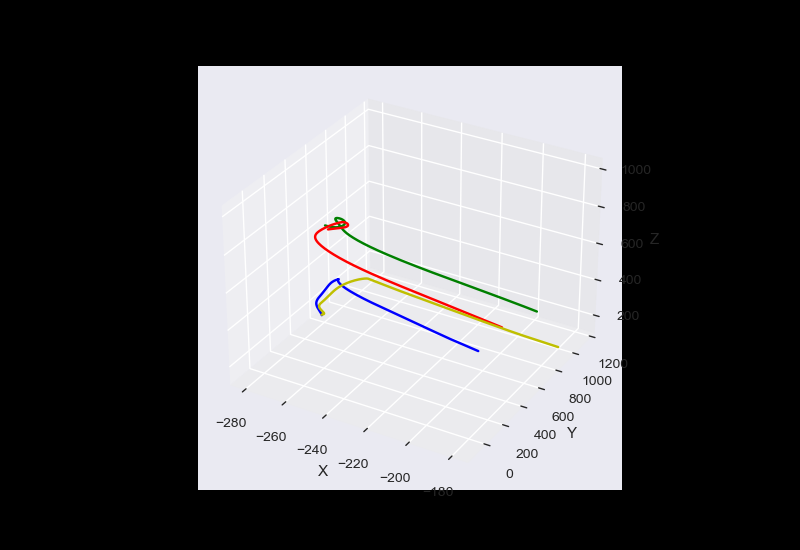

In [4]:
data_len,_ = fh_aligned_demo.shape
fh_y_demo = fh_aligned_demo.T
fl_y_demo = fl_aligned_demo.T
mh_y_demo = mh_aligned_demo.T
ml_y_demo = ml_aligned_demo.T

# DMP learning
fh_dmp = dmp_discrete(n_dmps=fh_y_demo.shape[0], n_bfs=100, dt=1.0/data_len)
fl_dmp = dmp_discrete(n_dmps=fl_y_demo.shape[0], n_bfs=100, dt=1.0/data_len)  
mh_dmp = dmp_discrete(n_dmps=mh_y_demo.shape[0], n_bfs=100, dt=1.0/data_len)
ml_dmp = dmp_discrete(n_dmps=ml_y_demo.shape[0], n_bfs=100, dt=1.0/data_len)

fh_dmp.learning(fh_y_demo, plot=False) 
fl_dmp.learning(fl_y_demo, plot=False)
mh_dmp.learning(mh_y_demo, plot=False)
ml_dmp.learning(ml_y_demo, plot=False)

# DMP reproduction
fh_y_reproduce, fh_dy_reproduce, fh_ddy_reproduce = fh_dmp.reproduce()
fl_y_reproduce, fl_dy_reproduce, fl_ddy_reproduce = fl_dmp.reproduce()
mh_y_reproduce, mh_dy_reproduce, mh_ddy_reproduce = mh_dmp.reproduce()
ml_y_reproduce, ml_dy_reproduce, ml_ddy_reproduce = ml_dmp.reproduce()

# plot the reproduced trajectory
fig = plt.figure()
ax1 = plt.axes(projection='3d')  #绘制空间曲线
ax1.plot3D(fh_y_reproduce[:,0],fh_y_reproduce[:,1],fh_y_reproduce[:,2],'g')
ax1.plot3D(fl_y_reproduce[:,0],fl_y_reproduce[:,1],fl_y_reproduce[:,2],'b')
ax1.plot3D(mh_y_reproduce[:,0],mh_y_reproduce[:,1],mh_y_reproduce[:,2],'r')
ax1.plot3D(ml_y_reproduce[:,0],ml_y_reproduce[:,1],ml_y_reproduce[:,2],'y')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

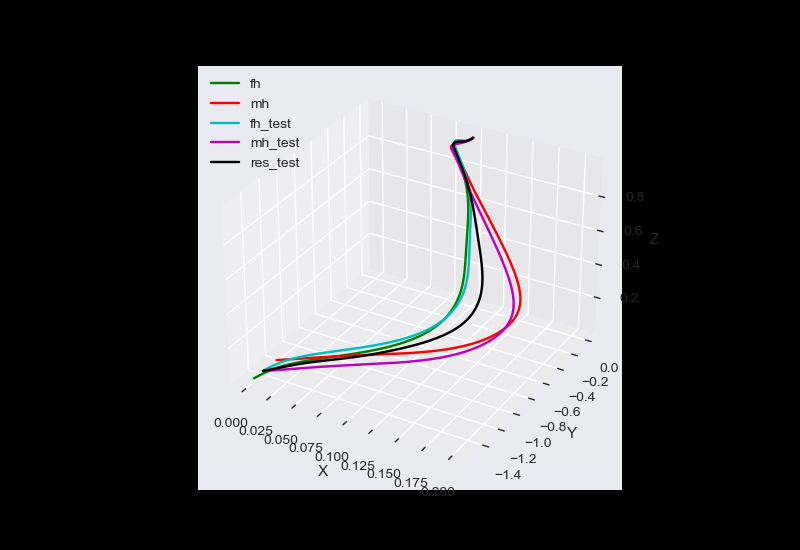

In [18]:
# DMP reproduction
fh_y_reproduce, fh_dy_reproduce, fh_ddy_reproduce = fh_dmp.reproduce(tau=1, initial=[0,-1.5,0], goal=[0.1,0,1])
fl_y_reproduce, fl_dy_reproduce, fl_ddy_reproduce = fl_dmp.reproduce(tau=1, initial=[0,-1.5,0], goal=[0.1,0,0.6])
mh_y_reproduce, mh_dy_reproduce, mh_ddy_reproduce = mh_dmp.reproduce(tau=1, initial=[0,-1.25,0], goal=[0.1,0,1])
ml_y_reproduce, ml_dy_reproduce, ml_ddy_reproduce = ml_dmp.reproduce(tau=1, initial=[0,-1.25,0], goal=[0.1,0,0.6])

fh_test_y_reproduce, fh_test_dy_reproduce, fh_test_ddy_reproduce = fh_dmp.reproduce(tau=1, initial=[0,-1.4,0], goal=[0.1,0,1])
mh_test_y_reproduce, mh_test_dy_reproduce, mh_test_ddy_reproduce = mh_dmp.reproduce(tau=1, initial=[0,-1.4,0], goal=[0.1,0,1])

res_test_y_reproduce = 0.1/0.25 * mh_test_y_reproduce + 0.15/0.25 * fh_test_y_reproduce

# plot the reproduced trajectory
fig = plt.figure()
ax1 = plt.axes(projection='3d')  #绘制空间曲线
ax1.plot3D(fh_y_reproduce[:,0],fh_y_reproduce[:,1],fh_y_reproduce[:,2],'g')
# ax1.plot3D(fl_y_reproduce[:,0],fl_y_reproduce[:,1],fl_y_reproduce[:,2],'b')
ax1.plot3D(mh_y_reproduce[:,0],mh_y_reproduce[:,1],mh_y_reproduce[:,2],'r')
# ax1.plot3D(ml_y_reproduce[:,0],ml_y_reproduce[:,1],ml_y_reproduce[:,2],'y')

ax1.plot3D(fh_test_y_reproduce[:,0],fh_test_y_reproduce[:,1],fh_test_y_reproduce[:,2],'c')
ax1.plot3D(mh_test_y_reproduce[:,0],mh_test_y_reproduce[:,1],mh_test_y_reproduce[:,2],'m')
ax1.plot3D(res_test_y_reproduce[:,0],res_test_y_reproduce[:,1],res_test_y_reproduce[:,2],'k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend(['fh','mh','fh_test','mh_test','res_test'], loc='upper left')

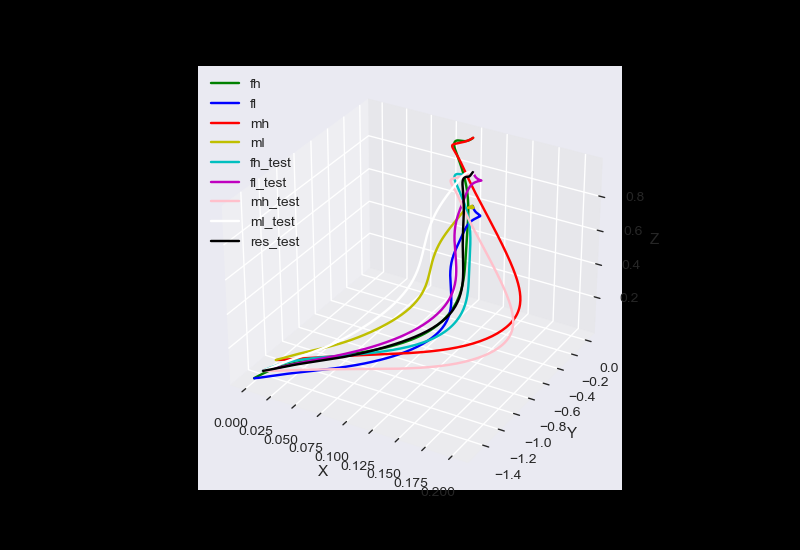

In [16]:
# DMP reproduction
fh_y_reproduce, fh_dy_reproduce, fh_ddy_reproduce = fh_dmp.reproduce(tau=1, initial=[0,-1.5,0], goal=[0.1,0,1])
fl_y_reproduce, fl_dy_reproduce, fl_ddy_reproduce = fl_dmp.reproduce(tau=1, initial=[0,-1.5,0], goal=[0.1,0,0.6])
mh_y_reproduce, mh_dy_reproduce, mh_ddy_reproduce = mh_dmp.reproduce(tau=1, initial=[0,-1.25,0], goal=[0.1,0,1])
ml_y_reproduce, ml_dy_reproduce, ml_ddy_reproduce = ml_dmp.reproduce(tau=1, initial=[0,-1.25,0], goal=[0.1,0,0.6])

fh_test_y_reproduce, fh_test_dy_reproduce, fh_test_ddy_reproduce = fh_dmp.reproduce(tau=1, initial=[0,-1.4,0], goal=[0.1,0,0.8])
fl_test_y_reproduce, fl_test_dy_reproduce, fl_test_ddy_reproduce = fl_dmp.reproduce(tau=1, initial=[0,-1.4,0], goal=[0.1,0,0.8])
mh_test_y_reproduce, mh_test_dy_reproduce, mh_test_ddy_reproduce = mh_dmp.reproduce(tau=1, initial=[0,-1.4,0], goal=[0.1,0,0.8])
ml_test_y_reproduce, ml_test_dy_reproduce, ml_test_ddy_reproduce = ml_dmp.reproduce(tau=1, initial=[0,-1.4,0], goal=[0.1,0,0.8])

res1_test_y_reproduce = 0.15/0.25 * fl_test_y_reproduce + 0.1/0.25 * ml_test_y_reproduce
res2_test_y_reproduce = 0.15/0.25 * fh_test_y_reproduce + 0.1/0.25 * mh_test_y_reproduce
res_test_y_reproduce = 0.2/0.4 * res1_test_y_reproduce + 0.2/0.4 * res2_test_y_reproduce


# plot the reproduced trajectory
fig = plt.figure()
ax1 = plt.axes(projection='3d')  #绘制空间曲线
ax1.plot3D(fh_y_reproduce[:,0],fh_y_reproduce[:,1],fh_y_reproduce[:,2],'g')
ax1.plot3D(fl_y_reproduce[:,0],fl_y_reproduce[:,1],fl_y_reproduce[:,2],'b')
ax1.plot3D(mh_y_reproduce[:,0],mh_y_reproduce[:,1],mh_y_reproduce[:,2],'r')
ax1.plot3D(ml_y_reproduce[:,0],ml_y_reproduce[:,1],ml_y_reproduce[:,2],'y')

ax1.plot3D(fh_test_y_reproduce[:,0],fh_test_y_reproduce[:,1],fh_test_y_reproduce[:,2],'c')
ax1.plot3D(fl_test_y_reproduce[:,0],fl_test_y_reproduce[:,1],fl_test_y_reproduce[:,2],'m')
ax1.plot3D(mh_test_y_reproduce[:,0],mh_test_y_reproduce[:,1],mh_test_y_reproduce[:,2],'pink')
ax1.plot3D(ml_test_y_reproduce[:,0],ml_test_y_reproduce[:,1],ml_test_y_reproduce[:,2],'w')

ax1.plot3D(res_test_y_reproduce[:,0],res_test_y_reproduce[:,1],res_test_y_reproduce[:,2],'k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend(['fh','fl','mh','ml','fh_test','fl_test','mh_test','ml_test','res_test'], loc='upper left')